In [15]:
from pathlib import Path
import os

# Detectar automáticamente si estamos en portátil o sobremesa
possible_roots = [
    Path("F:/JCMDataCenter/Cursos/Evolve Academy/Data Scientist IA/Futpeak"),  # sobremesa
    Path("C:/Users/juanm/Desktop/FUTPEAK/Futpeak")  # portátil
]

for path in possible_roots:
    if path.exists():
        project_root = path
        break
else:
    raise FileNotFoundError("⚠️ Ninguna ruta válida encontrada para project_root.")

# Establecer como directorio de trabajo
os.chdir(project_root)
print("📁 Directorio de trabajo actual:", Path.cwd())

📁 Directorio de trabajo actual: F:\JCMDataCenter\Cursos\Evolve Academy\Data Scientist IA\Futpeak


In [16]:
# ----------------------------------------------
# 🎯 FUTPEAK — Etapa 1: Carga y revisión inicial de los datos
# ----------------------------------------------

# 📌 Objetivo de esta celda:
# - Cargar los datasets base: logs de partidos (matchlogs) y metadatos de jugadores (metadata)
# - Hacer una revisión general de columnas, tipos, nulos y duplicados
# - Validar que ambas tablas están listas para ser combinadas y utilizadas en el modelado
# ----------------------------------------------

import pandas as pd
from pathlib import Path

# 📁 Ruta base donde están los datos procesados (ajustada a la estructura del proyecto)
data_path = Path("data/processed")

# 🧾 Archivos CSV de interés
matchlogs_path = data_path / "cleaned_matchlogs.csv"
metadata_path = data_path / "cleaned_metadata.csv"

# ----------------------------------------------
# 📥 Función de carga segura con información básica
# ----------------------------------------------
def load_csv(path, name):
    """
    Carga un CSV desde la ruta dada y muestra su tamaño.
    Si hay error, devuelve un DataFrame vacío.
    """
    try:
        df = pd.read_csv(path)
        print(f"✅ {name} cargado correctamente: {df.shape[0]} filas, {df.shape[1]} columnas.")
        return df
    except Exception as e:
        print(f"❌ Error al cargar {name}: {e}")
        return pd.DataFrame()

# 🔄 Cargar ambos datasets
matchlogs = load_csv(matchlogs_path, "matchlogs")
metadata = load_csv(metadata_path, "metadata")

# ----------------------------------------------
# 👀 Vista preliminar: estructura general
# ----------------------------------------------
def preview_df(df, name):
    print(f"\n📄 {name.upper()} — columnas:")
    print(df.columns.tolist())
    print(df.head(2))

preview_df(matchlogs, "matchlogs")
preview_df(metadata, "metadata")

# ----------------------------------------------
# 🧼 Revisión de duplicados y valores nulos
# ----------------------------------------------

# Duplicados en la clave primaria del metadata
print("\n🔍 Duplicados en Player_ID (metadata):", metadata["Player_ID"].duplicated().sum())

# Nulos por columna en cada dataset
print("\n🧼 Nulos en matchlogs:")
print(matchlogs.isnull().sum().sort_values(ascending=False))

print("\n🧼 Nulos en metadata:")
print(metadata.isnull().sum().sort_values(ascending=False))

# ----------------------------------------------
# ✅ Resultado esperado de esta etapa:
# - Confirmar que los archivos se cargan bien
# - Entender la estructura de las tablas y los tipos de datos
# - Saber si podemos unir ambas por Player_ID sin problemas
# - Identificar qué columnas deberemos imputar o limpiar
# ----------------------------------------------


✅ matchlogs cargado correctamente: 862529 filas, 46 columnas.
✅ metadata cargado correctamente: 17527 filas, 13 columnas.

📄 MATCHLOGS — columnas:
['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Position', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc']
        Player_name Player_ID Seasons        Date  Day  Competition  \
0  Luciano Abecasis  6c510f2d    2016  2016-02-05  Fri  Primera Div   
1  Luciano Abecasis  6c510f2d    2016  2016-0

In [17]:
# Conocer número total de jugadores 
total_unique_players = matchlogs['Player_ID'].nunique()
print("Total number of unique players:", total_unique_players)


Total number of unique players: 6182


In [18]:
import re

# ----------------------------------------------
# 🎯 Objetivo:
# Filtrar jugadores ofensivos (delanteros, extremos, mediapuntas)
# según la columna 'Position' del metadata.
# ----------------------------------------------

# 📌 Lista de abreviaciones ofensivas comunes en bases de datos
offensive_labels = ['CF', 'ST', 'FW', 'LW', 'RW', 'WF', 'IF', 'F']

# 🧵 Creamos un patrón de regex que busque esas etiquetas como palabra completa
# ya sea al inicio (^), al final ($), o entre guiones (ej: 'LW-RW' o 'CAM-ST')
pattern = r'(^|[-])(?:' + '|'.join(offensive_labels) + r')($|[-])'

# 🧪 Aplicamos el filtro sobre la columna 'Position' ignorando nulos
mask_attack = metadata['Position'].str.contains(pattern, na=False)

# 📊 Número de jugadores ofensivos detectados
print(f"🎯 Jugadores ofensivos encontrados: {mask_attack.sum()}")

# 🔍 Visualizamos los jugadores ofensivos
offensive_players = metadata[mask_attack]
display(offensive_players)



🎯 Jugadores ofensivos encontrados: 5070


C:\Users\juanm\AppData\Local\Temp\ipykernel_25004\4182563840.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_attack = metadata['Position'].str.contains(pattern, na=False)


,Player_ID,Player_name,Full_name,Url_template,Birth_date,Age,Position,Footed,Birth_place,Nationality,Club,First_name,Gender
1,db5ee72d,Ramon Abila,Ramón Darío Ábila,https://fbref.com/en/players/db5ee72d/Ramon-Abila,1989-10-14,35-198,FW,Right,"Córdoba, Argentina",Argentina,Huracán,Ramon,male
6,363ba6d7,Luciano Acosta,Luciano Federico Acosta,https://fbref.com/en/players/363ba6d7/Luciano-...,1994-05-31,30-334,AM-FC-FW-MF,Right,"Rosario, Argentina",Argentina,FC Dallas,Luciano,male
8,15741f49,Walter Acuna,NaN,https://fbref.com/en/players/15741f49/Walter-A...,1992-03-04,NaN,FW,NaN,NaN,Argentina,NaN,Walter,male
14,d9ebfcfa,Gabriel Alanis,NaN,https://fbref.com/en/players/d9ebfcfa/Gabriel-...,1994-03-16,31-045,AM-DF-FW-MF-WM,Left,"Córdoba, Argentina",Argentina,Huracán,Gabriel,male
16,834d0be5,Lucas Alario,Lucas Nicolás Alario,https://fbref.com/en/players/834d0be5/Lucas-Al...,1992-10-08,32-204,FW-LP,Right,"Tostado, Argentina",Argentina,Estudiantes (LP),Lucas,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17510,2ffd8d7b,Bernardo Vasconcelos,Bernardo Lino Castro Paes Vasconcelos,https://fbref.com/en/players/2ffd8d7b/Bernardo...,NaN,NaN,FW,NaN,NaN,Portugal,NaN,Bernardo,male
17511,238aa706,Ricardo Vaz Te,Ricardo Jorge Vaz,https://fbref.com/en/players/238aa706/Ricardo-...,NaN,NaN,FW-MF,Right,NaN,NaN,Ricardo Jorge Vaz Tê,Ricardo,male
17519,ce24310d,Hugo Vieira,Hugo Filipe Oliveira,https://fbref.com/en/players/ce24310d/Hugo-Vieira,NaN,NaN,FW,Right,NaN,Portugal,NaN,Hugo,male
17520,779fe525,Vieirinha,Adelino André Vieira Freitas,https://fbref.com/en/players/779fe525/Vieirinha,1986-01-24,39-114,AM-DF-FB-FW-MF-PAOK-WM,NaN,"Guimarães, Portugal",Portugal,Both,Vieirinha,unknown


In [19]:
# ----------------------------------------------
# 🎯 Etapa 2: Unión de datos, detección de ofensivos y cálculo de edad
# ----------------------------------------------
# Objetivos:
# - Filtrar jugadores ofensivos con un regex robusto.
# - Unir metadata y matchlogs por Player_ID.
# - Calcular edad por partido.
# - Revisar columnas con nulos que puedan requerir limpieza o imputación.
# ----------------------------------------------

import re

# 📌 Grupos posicionales útiles para análisis general (no solo atacantes)
POSITION_GROUPS = {
    'GOALKEEPER': ['GK'],
    'DEFENSIVE': ['CB', 'LB', 'RB', 'FB', 'LWB', 'RWB', 'SW', 'D'],
    'MIDFIELD': ['CM', 'DM', 'MF', 'AM'],
    'ATTACKING': ['CF', 'ST', 'F', 'FW', 'LW', 'RW', 'WF', 'IF', 'OL', 'OR']
}

# ----------------------------------------------
# 1. Filtrado de atacantes con regex + género masculino
# ----------------------------------------------
offensive_pattern = r'(^|-)(?:CF|ST|FW|LW|RW|WF|IF|F|OL|OR)($|-)'
df_attack = metadata[
    metadata['Position'].str.contains(offensive_pattern, na=False, regex=True) &
    (metadata['Gender'] == 'male')
].copy()

# 🔁 Asignamos grupo posicional para referencia (opcional)
def assign_position_group(position):
    for group, roles in POSITION_GROUPS.items():
        if any(pos in position for pos in roles):
            return group
    return 'UNKNOWN'

df_attack['Position_Group'] = df_attack['Position'].apply(assign_position_group)

print(f"\n✅ Jugadores ofensivos detectados: {df_attack['Player_ID'].nunique()}")

# ----------------------------------------------
# 2. Unir logs de partido con metadata filtrada
# ----------------------------------------------
df = matchlogs.merge(
    df_attack[['Player_ID', 'Position', 'Birth_date', 'Position_Group']],
    on='Player_ID', how='inner'  # Solo ofensivos
)

print(f"📊 Total de registros (partidos ofensivos): {df.shape[0]}")
print(f"👤 Jugadores ofensivos únicos: {df['Player_ID'].nunique()}")

# 🧼 Limpiar columnas duplicadas si las hubiera
if 'Position_x' in df.columns and 'Position_y' in df.columns:
    df['Position'] = df['Position_y']
    df.drop(columns=['Position_x', 'Position_y'], inplace=True)

# ----------------------------------------------
# 3. Cálculo de edad por partido
# ----------------------------------------------
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Birth_date'] = pd.to_datetime(df['Birth_date'], errors='coerce')
df['Age'] = (df['Date'] - df['Birth_date']).dt.days / 365.25

print("\n🧾 Ejemplo de edad calculada:")
print(df[['Player_ID', 'Date', 'Birth_date', 'Age']].head())

# ----------------------------------------------
# 4. Revisión de nulos (absoluto y %)
# ----------------------------------------------
nulls = df.isnull().sum()
null_pct = (nulls / len(df)) * 100
null_info = pd.DataFrame({'Nulls': nulls, 'Percentage': null_pct})
print("\n🔎 Nulos por columna (top 10):")
print(null_info[null_info['Nulls'] > 0].sort_values(by='Percentage', ascending=False).head(10))

# ----------------------------------------------
# ✅ Resultado:
# - Matchlogs unidos a metadata ofensiva
# - Edad calculada por partido
# - Nulos listados para preparar limpieza antes del modelado
# ----------------------------------------------




✅ Jugadores ofensivos detectados: 4068
📊 Total de registros (partidos ofensivos): 236194


C:\Users\juanm\AppData\Local\Temp\ipykernel_25004\4238351322.py:26: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  metadata['Position'].str.contains(offensive_pattern, na=False, regex=True) &


👤 Jugadores ofensivos únicos: 1539

🧾 Ejemplo de edad calculada:
  Player_ID       Date Birth_date        Age
0  db5ee72d 2024-02-11 1989-10-14  34.327173
1  db5ee72d 2024-02-11 1989-10-14  34.327173
2  db5ee72d 2024-02-14 1989-10-14  34.335387
3  db5ee72d 2024-02-14 1989-10-14  34.335387
4  db5ee72d 2024-02-24 1989-10-14  34.362765

🔎 Nulos por columna (top 10):
                        Nulls  Percentage
Penaltys_conceded      202693   85.816320
Penaltys_won           202693   85.816320
Tackles_won            164641   69.705835
Fouls_committed        164639   69.704988
Fouls_drawn            164639   69.704988
Crosses                164638   69.704565
Offsides               164636   69.703718
Percent_passes         162339   68.731212
Touches                161565   68.403516
Shot_creating_actions  161565   68.403516


In [20]:
# ----------------------------------------------
# 🎯 Etapa 2.1: Verificación de jugadores ofensivos perdidos en el merge
# ----------------------------------------------

# 1. Identificamos IDs ofensivos que no quedaron en el DataFrame final tras el merge
missing_ids = set(df_attack['Player_ID']) - set(df['Player_ID'])
print(f"🔍 Jugadores ofensivos que no entraron al merge: {len(missing_ids)}")

# 2. De esos IDs, verificamos si tienen registros en matchlogs
missing_in_logs = matchlogs[matchlogs['Player_ID'].isin(missing_ids)]
num_with_logs = missing_in_logs['Player_ID'].nunique()

print(f"📊 Jugadores con datos en matchlogs aunque no quedaron en df: {num_with_logs}")

# ----------------------------------------------
# 🔎 Posibles razones por las que un jugador ofensivo no entra al merge:
# - Tiene registros en metadata pero no jugó ningún partido (0 matchlogs).
# - Tiene matchlogs pero no fue incluido en el merge por filtrado previo (ej: género, posición).
# ----------------------------------------------



🔍 Jugadores ofensivos que no entraron al merge: 2529
📊 Jugadores con datos en matchlogs aunque no quedaron en df: 0


In [21]:
# Número total de jugadores del df
df['Player_ID'].unique()
# Número total de jugadores del df
len(df['Player_ID'].unique())



1539

In [22]:
unique_players = df[['Player_ID', 'Player_name']].drop_duplicates().sort_values('Player_name')
print(unique_players.to_string(index=False))


Player_ID                       Player_name
 14c2e443                      Aaron Nemane
 1fd66907                    Abdoul Diawara
 1757d7bb                        Abel Balbo
 ff41b91f                   Adamo Coulibaly
 8dfed6e9                      Adolfo Gaich
 86bc2c16                    Adrian Dabasse
 4ec73d8a                           Adriano
 d14229f3                      Adrien Hunou
 7330f886                     Adrián Dalmau
 68b35520                  Adrián Fernández
 48ad8e8f                       Adrián León
 098a28f8                    Agustin Hausch
 b5a3e7fe                  Agustín Auzmendi
 9a864054                  Agustín Balbuena
 a98f4de5                    Agustín Bouzat
 cc00dedf                 Agustín Cacabelos
 89fd5410                    Agustín Colazo
 06424feb                    Agustín Coscia
 6abc87e1                Agustín Curruhinca
 0cb368a6                      Agustín Díaz
 deb75bd4                   Agustín Fontana
 8ac63e52                     Ag

In [23]:
print("Columnas en df:", df.columns.tolist())


Columnas en df: ['Player_name', 'Player_ID', 'Seasons', 'Date', 'Day', 'Competition', 'Round', 'Home_Away', 'Result', 'Player_team', 'Rival_team', 'Start', 'Minutes', 'Goals', 'Assists', 'Penalty_kick', 'Penalty_kick_att', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Fouls_committed', 'Fouls_drawn', 'Offsides', 'Crosses', 'Tackles_won', 'Interceptions', 'Own_goals', 'Penaltys_won', 'Penaltys_conceded', 'Touches', 'Tackles', 'Blocks', 'xG', 'non_penalty_xG', 'x_assisted_G', 'Shot_creating_actions', 'Goal_creating_actions', 'Passes_completed', 'Passes_att', 'Percent_passes', 'Progressive_passes', 'Feet_control', 'Progressive_control', 'Dribling_suc', 'Birth_date', 'Position_Group', 'Position', 'Age']


In [24]:
# ----------------------------------------------
# 🎯 Etapa 3: Cálculo del rating ofensivo por partido y agregación por temporada
# ----------------------------------------------
# Objetivo:
# - Calcular un rating ponderado por 90 minutos
# - Agregar por jugador y año natural (temporada)
# ----------------------------------------------

# 1. Variables clave para la fórmula
rating_vars = ['Goals', 'Assists', 'Shots', 'Shots_on_target', 'Yellow_cards', 'Red_cards', 'Minutes']
df[rating_vars] = df[rating_vars].fillna(0)

# 2. Fórmula de rating (sin alterar aún, pero lista para ser ajustada)
def calculate_rating(row):
    score = (
        row['Goals'] * 5 +
        row['Assists'] * 4 +
        row['Shots_on_target'] * 0.5 +
        (row['Shots'] - row['Shots_on_target']) * 0.1 -
        row['Yellow_cards'] * 1 -
        row['Red_cards'] * 2
    )
    return score / (row['Minutes'] / 90) if row['Minutes'] > 0 else 0

df['rating_per_90'] = df.apply(calculate_rating, axis=1)

# 3. Año calendario para agrupar
df['Calendar_year'] = df['Date'].dt.year

print(f"🧾 Número de filas en df antes del groupby: {len(df)}")
print(df[['Player_ID', 'Date', 'Minutes', 'Goals']].head())

# 4. Agregamos por jugador y año calendario
df_season = df.groupby(['Player_ID', 'Calendar_year']).agg({
    'Minutes': 'sum',
    'Goals': 'sum',
    'Assists': 'sum',
    'rating_per_90': 'mean',
    'Age': 'mean'
}).reset_index()

# ✅ Evitar error si df_season está vacío
if not df_season.empty:
    sample_id = df_season['Player_ID'].iloc[0]
    print("\n📈 Evolución anual del primer jugador (ejemplo):")
    print(df_season[df_season['Player_ID'] == sample_id])
else:
    print("⚠️ df_season está vacío tras agregación. Verifica el filtrado previo.")

🧾 Número de filas en df antes del groupby: 236194
  Player_ID       Date  Minutes  Goals
0  db5ee72d 2024-02-11     34.0    0.0
1  db5ee72d 2024-02-11     34.0    0.0
2  db5ee72d 2024-02-14     30.0    0.0
3  db5ee72d 2024-02-14     30.0    0.0
4  db5ee72d 2024-02-24     24.0    0.0

📈 Evolución anual del primer jugador (ejemplo):
  Player_ID  Calendar_year  Minutes  Goals  Assists  rating_per_90        Age
0  0061247c           1999    503.0    0.0      0.0      -0.424862  22.092402
1  0061247c           2000    146.0    0.0      0.0      -0.441176  23.620123


In [25]:
# ----------------------------------------------
# 🎯 Etapa 4 (Binario): Detección del año pico y etiquetas binarias
# ----------------------------------------------

# 1. Detectar el año de mayor rendimiento para cada jugador
peak_info = (
    df_season
    .sort_values(['Player_ID', 'rating_per_90'], ascending=[True, False])
    .groupby('Player_ID')
    .first()
    .reset_index()
    .rename(columns={
        'Calendar_year': 'peak_year',
        'rating_per_90': 'peak_rating',
        'Age':            'age_at_peak'
    })
)

# 2. Unir esa información de pico a df_season
df_season = df_season.merge(
    peak_info[['Player_ID', 'peak_year', 'peak_rating', 'age_at_peak']],
    on='Player_ID', how='left'
)

# 3. Crear etiqueta binaria para Joven Estrella (young_star)
#    1 si age_at_peak ≤ 23, 0 en caso contrario
df_season['young_star'] = (df_season['age_at_peak'] <= 23).astype(int)

# 4. (Opcional) Crear etiqueta binaria para Estrellato Tardío (late_star)
#    1 si age_at_peak > 28 y no es young_star, 0 en caso contrario
df_season['late_star'] = (
    (df_season['age_at_peak'] > 28) &
    (df_season['young_star'] == 0)
).astype(int)

# 5. Ejemplo y distribución de las etiquetas binarias
print("\n📌 Ejemplo tras etiqueta binaria:")
print(df_season[['Player_ID','peak_year','peak_rating','age_at_peak','young_star','late_star']].head(10))

print("\n📊 Distribución young_star:")
print(df_season[['Player_ID','young_star']].drop_duplicates()['young_star'].value_counts())

print("\n📊 Distribución late_star (solo no‐jóvenes):")
print(df_season[df_season['young_star']==0][['Player_ID','late_star']].drop_duplicates()['late_star'].value_counts())



📌 Ejemplo tras etiqueta binaria:
  Player_ID  peak_year  peak_rating  age_at_peak  young_star  late_star
0  0061247c       1999    -0.424862    22.092402           1          0
1  0061247c       1999    -0.424862    22.092402           1          0
2  0085841a       2023     3.894406    21.341351           1          0
3  0085841a       2023     3.894406    21.341351           1          0
4  0085841a       2023     3.894406    21.341351           1          0
5  0085841a       2023     3.894406    21.341351           1          0
6  00d3206e       2006     1.710145          NaN           0          0
7  00d3206e       2006     1.710145          NaN           0          0
8  00d3206e       2006     1.710145          NaN           0          0
9  00d3206e       2006     1.710145          NaN           0          0

📊 Distribución young_star:
young_star
0    1183
1     356
Name: count, dtype: int64

📊 Distribución late_star (solo no‐jóvenes):
late_star
0    682
1    501
Name: count, dty


📊 Curvas promedio (primeras filas):
   young_star  year_since_debut  rating_per_90
0           0                 1       0.971262
1           0                 2       1.407234
2           0                 3       1.602193
3           0                 4       1.871857
4           0                 5       2.064885
5           0                 6       2.253223
6           0                 7       2.186533
7           0                 8       2.138689
8           0                 9       2.220918
9           0                10       2.327266


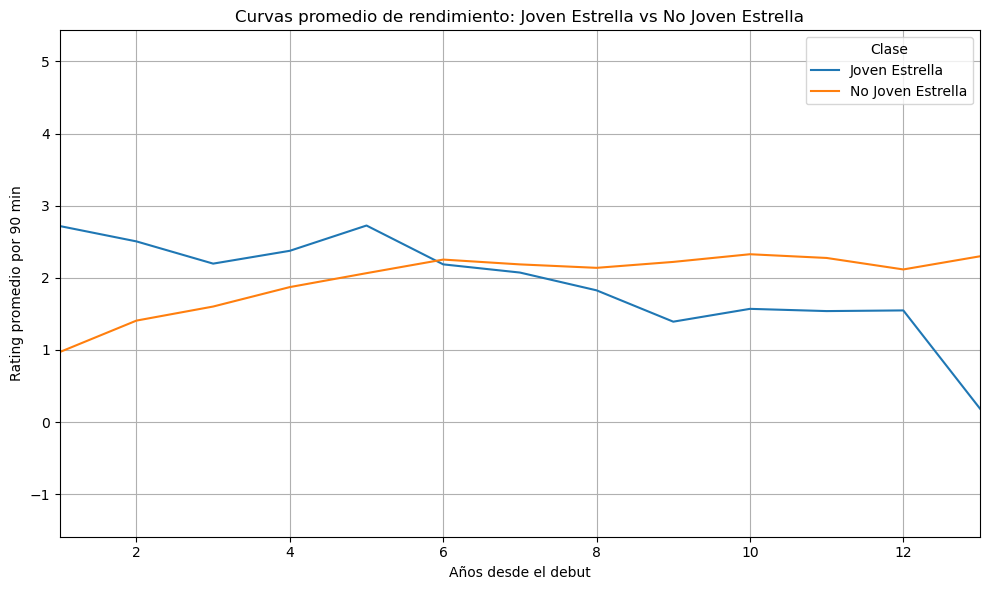

In [26]:
# ----------------------------------------------
# 🎯 Etapa 5 (Binario): Curvas promedio de rendimiento
# ----------------------------------------------
import matplotlib.pyplot as plt

# 1️⃣ Transformar fechas y calcular años desde el debut
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
debut_dates = df[df['Minutes'] > 0].groupby('Player_ID')['Date'].min()
df['debut_year'] = df['Player_ID'].map(debut_dates).dt.year
df['year_since_debut'] = df['Date'].dt.year - df['debut_year'] + 1

# 2️⃣ Construcción de career_df: métricas año a año
career_df = (
    df
    .groupby(['Player_ID', 'year_since_debut'], as_index=False)
    .agg(
        Minutes       = ('Minutes', 'sum'),
        rating_per_90 = ('rating_per_90', 'mean')
    )
)
# (Opcional) Filtrar años con al menos 300 minutos
# career_df = career_df[career_df['Minutes'] >= 300]

# 3️⃣ Añadir flag binario ‘young_star’
flags = df_season[['Player_ID', 'young_star']].drop_duplicates()
career_df = career_df.merge(flags, on='Player_ID', how='left')

# 4️⃣ Calcular curvas promedio por etiqueta
curves = (
    career_df
    .groupby(['young_star', 'year_since_debut'])['rating_per_90']
    .mean()
    .reset_index()
)

print("\n📊 Curvas promedio (primeras filas):")
print(curves.head(10))

# 5️⃣ Visualización: Joven Estrella vs No Joven Estrella
plt.figure(figsize=(10, 6))
for flag, label in [(1, 'Joven Estrella'), (0, 'No Joven Estrella')]:
    subset = curves[curves['young_star'] == flag]
    plt.plot(
        subset['year_since_debut'],
        subset['rating_per_90'],
        label=label
    )
plt.title("Curvas promedio de rendimiento: Joven Estrella vs No Joven Estrella")
plt.xlabel("Años desde el debut")
plt.ylabel("Rating promedio por 90 min")
plt.grid(True)
plt.legend(title="Clase")
plt.xlim(1, 13)
plt.tight_layout()
plt.show()


In [28]:
# ----------------------------------------------
# 🎯 Etapa 6 (Binario): Construcción del dataset de modelado
# ----------------------------------------------
import pandas as pd

# 1️⃣ Filtrar los primeros 3 años desde el debut
early_years = career_df[career_df['year_since_debut'] <= 3]

# 2️⃣ Pivotar a formato ancho: rating y minutos
pivot_rating = (
    early_years
    .pivot(index='Player_ID', columns='year_since_debut', values='rating_per_90')
    .rename(columns=lambda y: f'rating_year_{y}')
)
pivot_minutes = (
    early_years
    .pivot(index='Player_ID', columns='year_since_debut', values='Minutes')
    .rename(columns=lambda y: f'minutes_year_{y}')
)

# 3️⃣ Concatenar las características base
df_model = pd.concat([pivot_rating, pivot_minutes], axis=1)

# 4️⃣ Feature engineering adicional
# – Suma total de minutos en los 3 primeros años
mins_cols = [c for c in df_model.columns if c.startswith('minutes_year_')]
df_model['minutes_sum'] = df_model[mins_cols].sum(axis=1)

# – Peso de fiabilidad por año (minutos / 600)
for i in [1, 2, 3]:
    col = f'minutes_year_{i}'
    if col in df_model:
        df_model[f'minutes_weight_{i}'] = df_model[col].clip(0, 600) / 600

# – Crecimientos interanuales de rating
if all(c in df_model for c in ['rating_year_1','rating_year_2']):
    df_model['growth_2_1'] = df_model['rating_year_2'] - df_model['rating_year_1']
if all(c in df_model for c in ['rating_year_2','rating_year_3']):
    df_model['growth_3_2'] = df_model['rating_year_3'] - df_model['rating_year_2']

# – Tendencia larga año 3 vs 1
if all(c in df_model for c in ['rating_year_1','rating_year_3']):
    df_model['rating_trend'] = df_model['rating_year_3'] - df_model['rating_year_1']
if all(c in df_model for c in ['minutes_year_1','minutes_year_3']):
    df_model['minutes_trend'] = df_model['minutes_year_3'] - df_model['minutes_year_1']

# 5️⃣ Añadir la etiqueta binaria 'young_star'
#    Obtenida en df_season (o en career_df) en Etapa 4
#    Aquí usamos la primera aparición de young_star por jugador:
binary_map = career_df[['Player_ID', 'young_star']].drop_duplicates()
df_model = df_model.merge(binary_map, on='Player_ID', how='inner')

# 6️⃣ Filtrar jugadores con al menos un año de rating
rating_cols = [c for c in df_model.columns if c.startswith('rating_year_')]
valid = df_model[rating_cols].notna().sum(axis=1) >= 1
df_model = df_model[valid].copy()

# 7️⃣ Rellenar nulos restantes (para RandomForest, XGBoost...)
df_model.fillna(0, inplace=True)

# 8️⃣ Verificación final
print("\n📦 Dataset binario para modelado:")
print(df_model.head())

print("\n🎯 Distribución de 'young_star':")
print(df_model['young_star'].value_counts())




📦 Dataset binario para modelado:
  Player_ID  rating_year_0  rating_year_1  rating_year_2  rating_year_3  \
0  0061247c            0.0      -0.424862      -0.441176       0.000000   
1  0085841a            0.0       0.799376       3.894406       0.564313   
2  00d3206e            0.0       1.710145      -0.369318      -0.103687   
3  00f0e85a            0.0       5.000000       0.000000       0.000000   
4  0118dd71            0.0       0.000000      -0.333333      -0.071429   

   minutes_year_0  minutes_year_1  minutes_year_2  minutes_year_3  \
0             0.0           503.0           146.0             0.0   
1             0.0          2441.0          1066.0          1717.0   
2             0.0           967.0          1201.0           744.0   
3             0.0            90.0             0.0             0.0   
4             0.0           900.0           270.0          1260.0   

   minutes_sum  minutes_weight_1  minutes_weight_2  minutes_weight_3  \
0        649.0          0.83

In [29]:
# ----------------------------------------------
# Cell 7 (Binario): División del dataset y codificación del target
# ----------------------------------------------

from sklearn.model_selection import train_test_split

# 1️⃣ Reestablecer índice
df_model = df_model.reset_index(drop=True)

# 2️⃣ Nuestro target binario ya es 0/1 en 'young_star' – no necesitamos LabelEncoder

# 3️⃣ Obtener un DataFrame de jugadores únicos con su etiqueta
player_targets = df_model.drop_duplicates('Player_ID')[['Player_ID', 'young_star']]

# 4️⃣ División train/test por jugador, estratificada por young_star
train_ids, test_ids = train_test_split(
    player_targets['Player_ID'],
    test_size=0.2,
    stratify=player_targets['young_star'],
    random_state=42
)

# 5️⃣ Crear los subconjuntos finales
train_df = df_model[df_model['Player_ID'].isin(train_ids)].copy()
test_df  = df_model[df_model['Player_ID'].isin(test_ids)].copy()

# 6️⃣ Separar X e y
X_train = train_df.drop(columns=['Player_ID', 'young_star'])
y_train = train_df['young_star']

X_test  = test_df.drop(columns=['Player_ID', 'young_star'])
y_test  = test_df['young_star']

# ----------------------------------------------
# 🔍 Verificación de tamaño y balance
# ----------------------------------------------
print(f"✅ Train: {X_train.shape[0]} filas, {train_df['Player_ID'].nunique()} jugadores únicos")
print(f"✅ Test:  {X_test.shape[0]} filas, {test_df['Player_ID'].nunique()} jugadores únicos")
print("🎯 Balance en train:", y_train.value_counts(normalize=True).rename('pct').round(2).to_frame())
print("🎯 Balance en test: ", y_test.value_counts(normalize=True).rename('pct').round(2).to_frame())



✅ Train: 1231 filas, 1231 jugadores únicos
✅ Test:  308 filas, 308 jugadores únicos
🎯 Balance en train:              pct
young_star      
0           0.77
1           0.23
🎯 Balance en test:               pct
young_star      
0           0.77
1           0.23


In [31]:
# ----------------------------------------------
# Cell 8: Entrenamiento y evaluación de modelos binarios
# ----------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef
)

# 1️⃣ Definir los modelos
models = {
    'RandomForest': RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        learning_rate=0.05,
        max_depth=6,
        n_estimators=300,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        random_state=42
    )
}

# Si quieres añadir LightGBM y la tienes instalada, descomenta:
# from lightgbm import LGBMClassifier
# models['LightGBM'] = LGBMClassifier(
#     objective='binary',
#     learning_rate=0.05,
#     n_estimators=300,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )

# 2️⃣ Entrenar y evaluar cada modelo
for name, model in models.items():
    print(f"\n🔧 Entrenando modelo: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Métricas principales
    acc   = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    mcc   = matthews_corrcoef(y_test, y_pred)

    print(f"\n📊 Resultados para {name}:")
    print(f"✅ Accuracy: {acc:.3f}")
    print(f"🧠 Kappa Score: {kappa:.3f}")
    print(f"📈 MCC: {mcc:.3f}\n")

    # Reporte de clasificación (0 = No Joven, 1 = Joven)
    print("📄 Classification Report:")
    print(classification_report(
        y_test, y_pred,
        target_names=['No Joven', 'Joven']
    ))

    # Matriz de confusión
    print("📉 Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))



🔧 Entrenando modelo: RandomForest

📊 Resultados para RandomForest:
✅ Accuracy: 0.782
🧠 Kappa Score: 0.191
📈 MCC: 0.237

📄 Classification Report:
              precision    recall  f1-score   support

    No Joven       0.80      0.96      0.87       237
       Joven       0.59      0.18      0.28        71

    accuracy                           0.78       308
   macro avg       0.69      0.57      0.58       308
weighted avg       0.75      0.78      0.74       308

📉 Confusion Matrix:
[[228   9]
 [ 58  13]]

🔧 Entrenando modelo: XGBoost


c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\xgboost\training.py:183: UserWarning: [23:03:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Resultados para XGBoost:
✅ Accuracy: 0.766
🧠 Kappa Score: 0.227
📈 MCC: 0.239

📄 Classification Report:
              precision    recall  f1-score   support

    No Joven       0.81      0.91      0.86       237
       Joven       0.49      0.28      0.36        71

    accuracy                           0.77       308
   macro avg       0.65      0.60      0.61       308
weighted avg       0.73      0.77      0.74       308

📉 Confusion Matrix:
[[216  21]
 [ 51  20]]


In [32]:
# ----------------------------------------------
# 🎯 Etapa 9: Limpieza de outliers extremos en ratings
# ----------------------------------------------
# Objetivo:
# - Asegurar que ningún valor de rating por 90 min sea irreal (ej: >10)
# - Recalcular las variables derivadas después de aplicar los límites
# ----------------------------------------------

# 1. Identificamos las columnas de rating (por año + promedio)
rating_cols = [col for col in df_model.columns if col.startswith('rating_year_') or col == 'avg_rating']

# 2. Aplicamos límites razonables (ej: 0 a 10 como escala humana)
for col in rating_cols:
    df_model[col] = df_model[col].clip(lower=0, upper=10)

# 3. Recalculamos variables derivadas (porque el clipping puede haberlas cambiado)
if 'rating_year_2' in df_model and 'rating_year_1' in df_model:
    df_model['growth_2_1'] = df_model['rating_year_2'] - df_model['rating_year_1']
if 'rating_year_3' in df_model and 'rating_year_2' in df_model:
    df_model['growth_3_2'] = df_model['rating_year_3'] - df_model['rating_year_2']

# 4. Verificación de rangos finales
print("\n📊 Verificación de estadísticas tras limpieza:")
print(df_model[rating_cols].describe())



📊 Verificación de estadísticas tras limpieza:
       rating_year_0  rating_year_1  rating_year_2  rating_year_3
count         1539.0    1539.000000    1539.000000    1539.000000
mean             0.0       1.323460       1.214171       1.146402
std              0.0       2.036060       1.782393       1.609075
min              0.0       0.000000       0.000000       0.000000
25%              0.0       0.000000       0.000000       0.000000
50%              0.0       0.409091       0.367647       0.402807
75%              0.0       1.947715       1.964500       1.888236
max              0.0      10.000000      10.000000      10.000000


In [33]:
# ----------------------------------------------
# Cell 10: Optimización de RandomForest con RandomizedSearchCV
# ----------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef
)

# 1️⃣ Espacio de búsqueda de hiperparámetros
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# 2️⃣ Modelo base
rf = RandomForestClassifier(random_state=42)

# 3️⃣ RandomizedSearchCV con CV=3 y paralelización
rf_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,        # prueba 50 combinaciones
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 4️⃣ Búsqueda de los mejores hiperparámetros
print("🔍 Buscando mejores hiperparámetros para RandomForest...")
rf_search.fit(X_train, y_train)

# 5️⃣ Evaluación del mejor modelo
best_rf = rf_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n✅ Mejores hiperparámetros encontrados:")
print(rf_search.best_params_)

print("\n📊 Rendimiento tras tuning:")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\n📄 Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=['No Joven','Joven']
))
print("\n📉 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"\n🧠 Kappa Score: {cohen_kappa_score(y_test, y_pred):.3f}")
print(f"📈 MCC:            {matthews_corrcoef(y_test, y_pred):.3f}")


🔍 Buscando mejores hiperparámetros para RandomForest...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
51 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
38 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constra


✅ Mejores hiperparámetros encontrados:
{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}

📊 Rendimiento tras tuning:
✅ Accuracy: 0.756

📄 Classification Report:
              precision    recall  f1-score   support

    No Joven       0.79      0.94      0.86       237
       Joven       0.42      0.15      0.23        71

    accuracy                           0.76       308
   macro avg       0.61      0.55      0.54       308
weighted avg       0.70      0.76      0.71       308


📉 Matriz de Confusión:
[[222  15]
 [ 60  11]]

🧠 Kappa Score: 0.118
📈 MCC:            0.139


In [34]:
# ----------------------------------------------
# Cell 11: Optimización de RandomForest con GridSearchCV
# ----------------------------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    cohen_kappa_score,
    matthews_corrcoef
)

# 1️⃣ Definir un grid pequeño y razonable
param_grid = {
    'n_estimators':      [200, 400],
    'max_depth':         [6, 10],
    'min_samples_split': [5, 10],
    'max_features':      ['sqrt', 'log2'],
    'bootstrap':         [True, False]
}

# 2️⃣ Modelo base
rf = RandomForestClassifier(random_state=42)

# 3️⃣ GridSearchCV con CV=3 y paralelización
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 4️⃣ Ejecutar la búsqueda
print("🔍 Ejecutando GridSearchCV para RandomForest...")
grid_search.fit(X_train, y_train)

# 5️⃣ Evaluar el mejor modelo encontrado
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n✅ Mejores hiperparámetros:")
print(grid_search.best_params_)

print("\n📊 Rendimiento tras tuning:")
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\n📄 Classification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=['No Joven Estrella', 'Joven Estrella']
))
print("\n📉 Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred))
print(f"\n🧠 Kappa Score: {cohen_kappa_score(y_test, y_pred):.3f}")
print(f"📈 MCC:            {matthews_corrcoef(y_test, y_pred):.3f}")



🔍 Ejecutando GridSearchCV para RandomForest...
Fitting 3 folds for each of 32 candidates, totalling 96 fits

✅ Mejores hiperparámetros:
{'bootstrap': True, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 400}

📊 Rendimiento tras tuning:
✅ Accuracy: 0.773

📄 Classification Report:
                   precision    recall  f1-score   support

No Joven Estrella       0.80      0.95      0.86       237
   Joven Estrella       0.52      0.20      0.29        71

         accuracy                           0.77       308
        macro avg       0.66      0.57      0.58       308
     weighted avg       0.73      0.77      0.73       308


📉 Matriz de Confusión:
[[224  13]
 [ 57  14]]

🧠 Kappa Score: 0.182
📈 MCC:            0.212


# Sugerencias Julio

* Meter medias e intervalos de confianza en gráfica

* Usar los dos modelos

* Tener todo en una página de streamlit

* Feedback

* Formulario de google no más de 10 preguntas (opciones y caja de comentarios)

* ¿Cómo vender? Idea de negocio, corto, medio y largo plazo

* Vídeo presentación para ir enseñando a gente de Evolve y empresas.

C:\Users\juanm\AppData\Local\Temp\ipykernel_40716\751709336.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\juanm\miniconda3\envs\futpeak\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


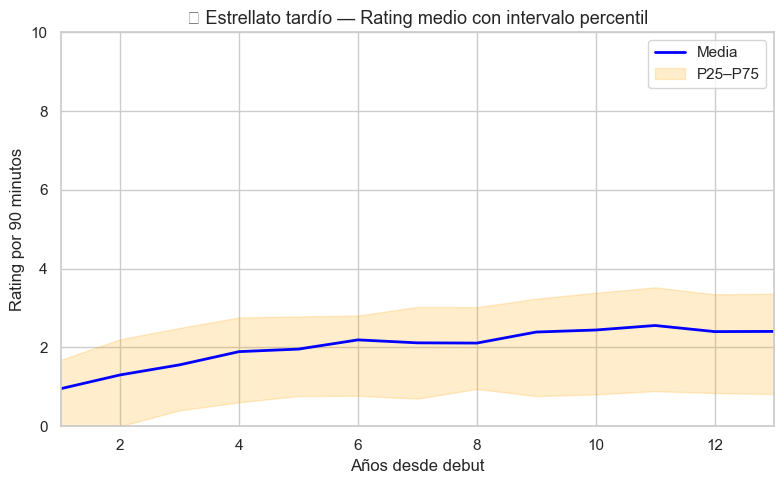

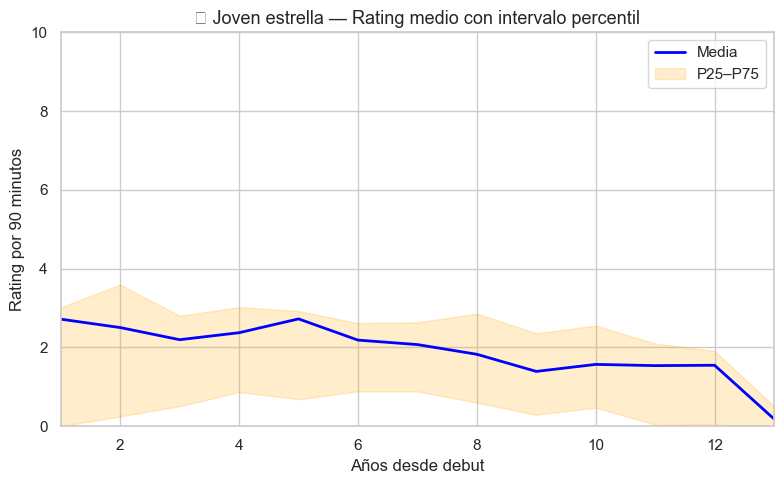

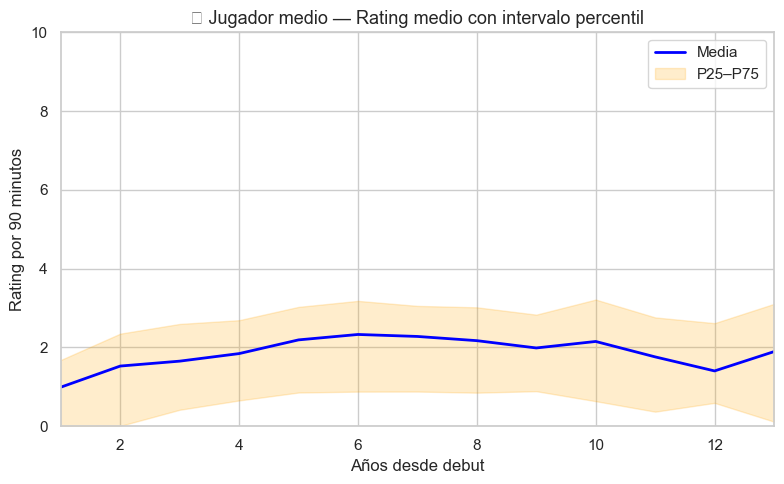

In [ ]:
# ----------------------------------------------
# 🎯 Análisis visual de curvas con bandas de variabilidad (P25–P75)
# ----------------------------------------------
# Objetivo:
# - Visualizar el rendimiento medio por grupo (rating_per_90)
# - Añadir bandas de percentiles (25 y 75) como representación de dispersión
# ----------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. Agrupamos por grupo y año relativo desde debut
group_stats = career_df.groupby(['peak_group', 'year_since_debut'])['rating_per_90'].agg(
    mean='mean',
    std='std',
    count='count',
    p25=lambda x: np.percentile(x, 25),
    p75=lambda x: np.percentile(x, 75)
).reset_index()

# 2. Limitamos a los primeros 13 años desde debut
group_stats = group_stats[group_stats['year_since_debut'] <= 13]

# ----------------------------------------------
# 3. Gráfica por grupo con bandas percentiles
# ----------------------------------------------
sns.set(style="whitegrid")
unique_groups = group_stats['peak_group'].unique()

for group in unique_groups:
    subset = group_stats[group_stats['peak_group'] == group]

    plt.figure(figsize=(8, 5))

    # Línea media
    plt.plot(
        subset['year_since_debut'], subset['mean'],
        label='Media', color='blue', linewidth=2
    )

    # Banda de percentiles (P25–P75)
    plt.fill_between(
        subset['year_since_debut'],
        subset['p25'],
        subset['p75'],
        color='orange',
        alpha=0.2,
        label='P25–P75'
    )

    # Configuración del gráfico
    plt.title(f"📊 {group.capitalize()} — Rating medio con intervalo percentil", fontsize=13)
    plt.xlabel("Años desde debut")
    plt.ylabel("Rating por 90 minutos")
    plt.xlim(1, 13)
    plt.ylim(0, 10)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
print("🔍 df_season shape:", df_season.shape)
print("🔍 df_season columnas:", df_season.columns.tolist())
print("🔍 Valores únicos en peak_group:", df_season['peak_group'].unique())
print("🔍 Muestra de df_season:")
display(df_season.head())


🔍 df_season shape: (11293, 11)
🔍 df_season columnas: ['Player_ID', 'Calendar_year', 'Minutes', 'Goals', 'Assists', 'rating_per_90', 'Age', 'peak_year', 'peak_rating', 'age_at_peak', 'peak_group']
🔍 Valores únicos en peak_group: ['joven estrella' 'estrellato tardío' 'jugador medio']
🔍 Muestra de df_season:


,Player_ID,Calendar_year,Minutes,Goals,Assists,rating_per_90,Age,peak_year,peak_rating,age_at_peak,peak_group
0,0061247c,1999,503.0,0.0,0.0,-0.424862,22.092402,1999,-0.424862,22.092402,joven estrella
1,0061247c,2000,146.0,0.0,0.0,-0.441176,23.620123,1999,-0.424862,22.092402,joven estrella
2,0085841a,2022,2441.0,1.0,7.0,0.799376,20.473967,2023,3.894406,21.341351,joven estrella
3,0085841a,2023,1066.0,2.0,1.0,3.894406,21.341351,2023,3.894406,21.341351,joven estrella
4,0085841a,2024,1717.0,1.0,3.0,0.564313,22.531436,2023,3.894406,21.341351,joven estrella


In [ ]:
# ----------------------------------------------
# 🎯 Etapa final: Guardado de modelo y recursos
# ----------------------------------------------

import joblib
from pathlib import Path

# 1. Ruta donde se guardan los objetos del modelo
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# 2. Aseguramos cuál es el mejor modelo (elige manualmente cuál usar)
final_model = grid_search.best_estimator_  # puedes cambiar esto a model, rf_search.best_estimator_, etc.

# 3. Guardamos el modelo entrenado
joblib.dump(final_model, 'model/futpeak_model_multi.joblib')

# 4. Guardamos el label encoder
joblib.dump(le, model_dir / "label_encoder.joblib")

# 5. Guardamos las columnas utilizadas para entrenar el modelo
joblib.dump(X_train.columns.tolist(), model_dir / "model_features.joblib")

# 6. Generamos las curvas promedio por grupo (de nuevo, con year_since_debut)
debut_years = df_season.groupby('Player_ID')['Calendar_year'].min().to_dict()
df_season = df_season.copy()
df_season['year_since_debut'] = df_season['Player_ID'].map(debut_years)
df_season['year_since_debut'] = df_season['Calendar_year'] - df_season['year_since_debut'] + 1

# ⚠️ Validar que no haya NaNs
df_season = df_season[df_season['year_since_debut'].notna()]

# Crear curvas
df_curves = (
    df_season.groupby(['peak_group', 'year_since_debut'])['rating_per_90']
    .mean()
    .reset_index()
    .rename(columns={'rating_per_90': 'rating_avg'})
)

# Guardar
joblib.dump(df_curves, 'model/curvas_promedio.joblib')
print("✅ Curvas promedio guardadas correctamente.")


print("✅ Modelo, encoder, columnas y curvas promedio guardados correctamente.")


✅ Curvas promedio guardadas correctamente.
✅ Modelo, encoder, columnas y curvas promedio guardados correctamente.


In [ ]:
import os
print("📁 ¿Existe el archivo después de guardar?", os.path.exists("model/curvas_promedio.joblib"))


📁 ¿Existe el archivo después de guardar? True


In [ ]:
print(df_curves.shape)
df_curves


(59, 3)


,peak_group,year_since_debut,rating_avg
0,estrellato tardío,1,0.954593
1,estrellato tardío,2,1.303665
2,estrellato tardío,3,1.559645
3,estrellato tardío,4,1.894204
4,estrellato tardío,5,1.959052
5,estrellato tardío,6,2.192625
6,estrellato tardío,7,2.117339
7,estrellato tardío,8,2.111588
8,estrellato tardío,9,2.391908
9,estrellato tardío,10,2.443210


In [ ]:
# Cuántos jugadores aportan datos a cada year_since_debut
players_per_year = career_df.groupby('year_since_debut')['Player_ID'].nunique().reset_index()
players_per_year.columns = ['Año desde debut', 'Nº jugadores']
print(players_per_year)



    Año desde debut  Nº jugadores
0                 0             1
1                 1          1539
2                 2          1127
3                 3          1011
4                 4           969
5                 5           961
6                 6           918
7                 7           922
8                 8           895
9                 9           887
10               10           765
11               11           518
12               12           287
13               13           155
14               14           111
15               15            85
16               16            59
17               17            35
18               18            21
19               19            13
20               20             7
21               21             4
22               22             2
23               25             1


In [ ]:
minutes_by_year = career_df.groupby('year_since_debut')['Minutes'].mean().reset_index()
print(minutes_by_year.head(20))


    year_since_debut      Minutes
0                  0     0.000000
1                  1   577.378168
2                  2  1066.750665
3                  3  1325.696340
4                  4  1449.253870
5                  5  1500.371488
6                  6  1559.076253
7                  7  1633.184382
8                  8  1670.498324
9                  9  1522.553551
10                10  1290.338562
11                11  1226.642857
12                12  1160.202091
13                13  1246.941935
14                14  1325.243243
15                15  1300.752941
16                16  1141.627119
17                17  1480.714286
18                18  1492.714286
19                19  1512.461538


In [ ]:
# Verificar cálculo del año de debut
df_tmp = df.copy()
df_tmp['Date'] = pd.to_datetime(df_tmp['Date'])
df_tmp['Natural_year'] = df_tmp['Date'].dt.year

# Agregamos debut por jugador
debut_by_player = df_tmp[df_tmp['Minutes'] > 0].groupby('Player_ID')['Natural_year'].min().reset_index()
debut_by_player.columns = ['Player_ID', 'Debut_year']

# Merge para revisar
df_debug = df_tmp.merge(debut_by_player, on='Player_ID')
df_debug['year_since_debut'] = df_debug['Natural_year'] - df_debug['Debut_year'] + 1

# Ahora buscamos valores extraños
print("\nJugadores con year_since_debut > 15:")
print(df_debug[df_debug['year_since_debut'] > 15][['Player_name', 'Natural_year', 'Debut_year', 'year_since_debut']].drop_duplicates())



Jugadores con year_since_debut > 15:
              Player_name  Natural_year  Debut_year  year_since_debut
139745      Sergio Agüero          2021        2006                16
143108        Rubén Ayala          1998        1974                25
146725  Gonzalo Bergessio          2022        2007                16
151909    Pablo Calandria          2016        2001                16
151933    Pablo Calandria          2017        2001                17
...                   ...           ...         ...               ...
231598     Olivier Giroud          2025        2010                16
232129      Yoan Gouffran          2020        2004                17
232288      Yoan Gouffran          2019        2004                16
232498     Elliot Grandin          2020        2005                16
233472  Antoine Griezmann          2025        2010                16

[142 rows x 4 columns]


In [ ]:
# Jugadores con más edad al final de su carrera
print("\nJugadores con mayor edad en dataset:")
print(df.groupby("Player_ID")["Age"].max().sort_values(ascending=False).head(10))



Jugadores con mayor edad en dataset:
Player_ID
a20a0ee8    48.484600
29cf8777    43.318275
3b64f69d    41.856263
4cd813d5    41.848049
7768235d    41.544148
6a11048a    41.004791
6d4d9e18    40.859685
96d19d5b    40.320329
8d8178ac    40.290212
12fe55da    39.920602
Name: Age, dtype: float64
